<a href="https://colab.research.google.com/github/mannatgit22/ML_Lab_Test/blob/main/ML_lab_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
!pip install -q optuna xgboost
import optuna
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score,accuracy_score

In [2]:
uploaded = files.upload()
df = pd.read_csv('loan_data.csv')
df.head()

Saving loan_data.csv to loan_data.csv


,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1


In [66]:
X = df.drop(columns=['loan_paid_back'])
y = df['loan_paid_back']

In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [68]:
num_features = X.select_dtypes(include=['int64','float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

In [69]:
xgb_model = XGBClassifier(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.85,
    colsample_bytree=0.85,
    min_child_weight=3,
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

model = Pipeline([
    ('preprocess', preprocessor),
    ('classifier', xgb_model)
])

In [70]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'income_loan_ratio',
       'credit_income_ratio', 'interest_loan_ratio', 'debt_credit_ratio',
       'loan_inco...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=3,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=400,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [71]:
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_test, y_pred_proba)
acc = accuracy_score(y_test, y_pred)

print("ROC-AUC:", auc)
print("Accuracy:", acc)

ROC-AUC: 0.9193986191944402
Accuracy: 0.9045185834436715


In [72]:
def subgroup_auc(column):
    results = {}
    for grp in X_test[column].astype(str).unique():
        mask = X_test[column].astype(str) == grp
        if mask.sum() > 10:
            auc = roc_auc_score(y_test[mask], y_pred_proba[mask])
            results[grp] = auc
    return results

edu_auc = subgroup_auc('education_level')
edu_auc

{"Bachelor's": np.float64(0.9204791297528103),
 "Master's": np.float64(0.917306645257637),
 'High School': np.float64(0.9167723643378524),
 'PhD': np.float64(0.9159062721474133),
 'Other': np.float64(0.9310735978759002)}

In [73]:
purpose_auc = subgroup_auc('loan_purpose')

purpose_df = pd.DataFrame(
    purpose_auc.items(),
    columns=['loan_purpose', 'AUC']
).sort_values(by='AUC', ascending=False)

print("Top 3 Loan Purposes:")
print(purpose_df.head(3))

print("\nBottom 3 Loan Purposes:")
print(purpose_df.tail(3))

Top 3 Loan Purposes:
  loan_purpose       AUC
1    Education  0.930412
4      Medical  0.925435
5     Vacation  0.925250

Bottom 3 Loan Purposes:
         loan_purpose       AUC
7               Other  0.920031
2  Debt consolidation  0.918545
6                 Car  0.909706


In [74]:
output = X_test.copy()
output['prediction_probability'] = y_pred_proba

output.to_csv('xgb_predictions.csv', index=False)

In [75]:
thresholds = np.arange(0.2, 0.9, 0.01)

best_acc = 0
best_t = 0

for t in thresholds:
    preds = (y_pred_proba >= t).astype(int)
    acc = accuracy_score(y_test, preds)
    if acc > best_acc:
        best_acc = acc
        best_t = t

print("Best threshold:", best_t)
print("Best accuracy:", best_acc)

Best threshold: 0.5000000000000002
Best accuracy: 0.9045185834436715


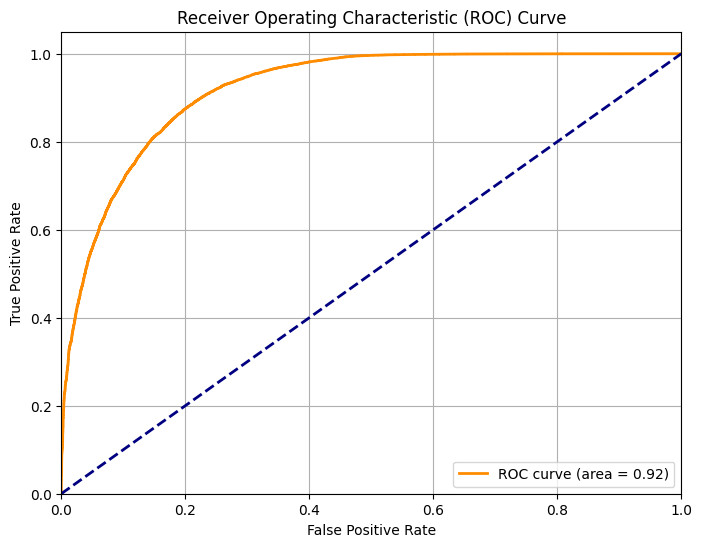

In [77]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [78]:
# Using Optuna XGBoost
from sklearn.model_selection import train_test_split

X_train_opt, X_valid_opt, y_train_opt, y_valid_opt = train_test_split(
    X_train, y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train
)

In [79]:
# Fit preprocessor only once
X_train_opt_trans = preprocessor.fit_transform(X_train_opt)
X_valid_opt_trans = preprocessor.transform(X_valid_opt)

In [82]:
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 700),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 5.0)
    }

    model = XGBClassifier(
        **params,
        eval_metric="logloss",
        tree_method="hist",
        random_state=42
    )

    model.fit(
        X_train_opt_trans, y_train_opt,
        eval_set=[(X_valid_opt_trans, y_valid_opt)],
        verbose=False
    )

    y_valid_pred = model.predict_proba(X_valid_opt_trans)[:,1]
    auc = roc_auc_score(y_valid_opt, y_valid_pred)

    return auc

In [83]:
import optuna

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
print("Best Parameters:", study.best_params)

[I 2025-11-28 05:41:48,566] A new study created in memory with name: no-name-0bc1a5c5-a1c3-4de6-84d7-52bb8b2fffc0
[I 2025-11-28 05:43:18,846] Trial 0 finished with value: 0.9158697578557772 and parameters: {'n_estimators': 553, 'max_depth': 9, 'learning_rate': 0.19610634411909011, 'subsample': 0.7732467038166538, 'colsample_bytree': 0.8602226919943761, 'min_child_weight': 5, 'gamma': 2.2976537468293485, 'reg_alpha': 2.6350503772079925, 'reg_lambda': 1.8904390269268145}. Best is trial 0 with value: 0.9158697578557772.
[I 2025-11-28 05:43:57,962] Trial 1 finished with value: 0.9183718539882872 and parameters: {'n_estimators': 472, 'max_depth': 5, 'learning_rate': 0.16998371550453195, 'subsample': 0.6566044063079542, 'colsample_bytree': 0.6585390832260223, 'min_child_weight': 7, 'gamma': 4.348380451195704, 'reg_alpha': 1.179502019274109, 'reg_lambda': 2.7036069934927562}. Best is trial 1 with value: 0.9183718539882872.
[I 2025-11-28 05:44:21,086] Trial 2 finished with value: 0.91834660944

Best AUC: 0.9190767835404361
Best Parameters: {'n_estimators': 671, 'max_depth': 3, 'learning_rate': 0.12376545356972138, 'subsample': 0.8369612684539851, 'colsample_bytree': 0.7883807574116606, 'min_child_weight': 7, 'gamma': 1.824684214785126, 'reg_alpha': 3.0113573273515417, 'reg_lambda': 3.4960720882067777}


In [85]:
best_params = study.best_params

xgb_model = XGBClassifier(
    **best_params,
    eval_metric="logloss",
    tree_method="hist",
    random_state=42
)

model = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", xgb_model)
])

model.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['id', 'annual_income', 'debt_to_income_ratio', 'credit_score',
       'loan_amount', 'interest_rate', 'income_loan_ratio',
       'credit_income_ratio', 'interest_loan_ratio', 'debt_credit_ratio',
       'loan_inco...
                               gamma=1.824684214785126, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.12376545356972138, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=3,
                               max_leaves=None, min_child_weight=7, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=671, n_jobs=None,
                               num_parallel_tree=None, ...))])

/tmp/ipython-input-3268449373.py:3: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  opt_vis.plot_optimization_history(study)


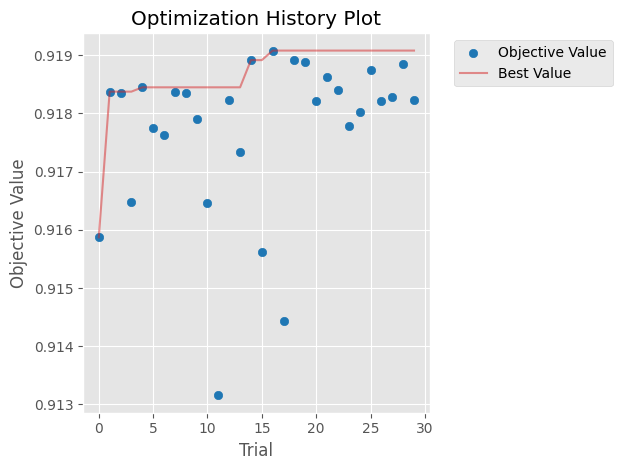

/tmp/ipython-input-3268449373.py:7: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  opt_vis.plot_param_importances(study)


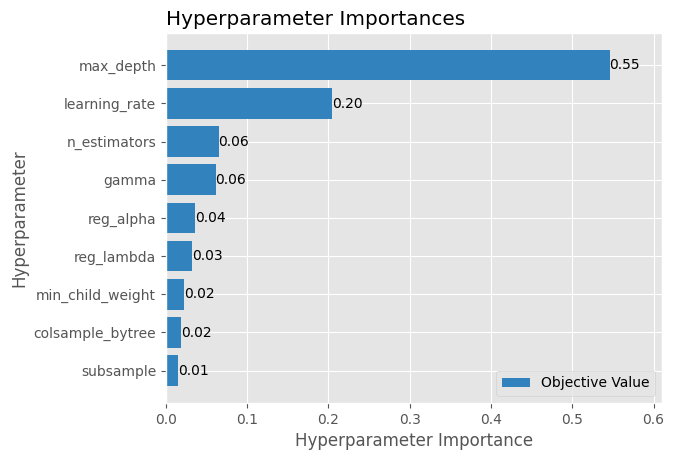

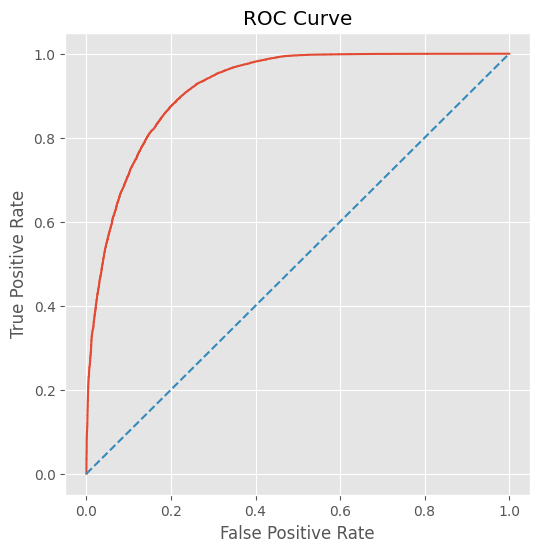

In [86]:
import optuna.visualization.matplotlib as opt_vis

opt_vis.plot_optimization_history(study)
plt.show()


opt_vis.plot_param_importances(study)
plt.show()


from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()